In [1]:
import logging
logging.root.handlers = []  # Jupyter messes up logging so needs a reset
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.cross_validation import train_test_split
from sklearn import linear_model
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from sklearn.neighbors import KNeighborsClassifier
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

2018-05-07 10:36:48,672 : INFO : 'pattern' package not found; tag filters are not available for English
/home/nikita/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
data = pd.read_csv('/home/nikita/PycharmProjects/natural_language/data/test_prepocess.csv')
data.head()

,stars,text,useful,funny
0,3,The good: mini doughnuts and americano friendl...,1,0
1,3,I really like the décor of the place and the w...,0,0
2,5,"Great service, clean and great food, this plac...",1,0
3,5,This place has never failed on me! \nLate nigh...,0,0
4,2,This is a fast food spin off from Paramount Fi...,1,1


In [3]:
train_data, test_data = train_test_split(data, test_size=0.1, random_state=42)
train_batch = train_data[0:10000]
test_batch = test_data[0:50000]

In [4]:
def evaluate_prediction(predictions, target, title="Confusion matrix"):
    print('accuracy %s' % accuracy_score(target, predictions))
    cm = confusion_matrix(target, predictions)
    print('confusion matrix\n %s' % cm)
    print('(row=expected, col=predicted)')
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(cm_normalized, title + ' Normalized')
    
def plot_confusion_matrix(cm, title='Матрица ошибок', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    my_tags = pd.unique(data.stars)
    tick_marks = np.arange(len(my_tags))
    target_names = my_tags
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('Исходные метки')
    plt.xlabel('Полученные метки')

def predict(vectorizer, classifier, data):
    data_features = vectorizer.transform(data.text)
    predictions = classifier.predict(data_features)
    target = data.stars
    evaluate_prediction(predictions, target)

In [5]:
import re
contractions = re.compile(r"'|-|\"")
# all non alphanumeric
symbols = re.compile(r'(\W+)', re.U)
# single character removal
singles = re.compile(r'(\s\S\s)', re.I|re.U)
# separators (any whitespace)
seps = re.compile(r'\s+')

# cleaner (order matters)
def clean(text): 
    text = text.lower()
    text = contractions.sub('', text)
    text = symbols.sub(r' \1 ', text)
    text = singles.sub(' ', text)
    text = seps.sub(' ', text)
    return text

# sentence splitter
alteos = re.compile(r'([!\?])')
def sentences(l):
    l = alteos.sub(r' \1 .', l).rstrip("(\.)*\n")
    return l.split(".")

In [10]:
def plots(label):
    my_df = None
    if label=='training':
        my_df = train_batch
    else:
        my_df = test_batch
    for i, row in my_df.iterrows():
        yield {'y':row.stars,\
        'x':[clean(s).split() for s in sentences(row.text)]}


In [11]:
%%time
# The corpus is small so can be read into memory
revtrain = list(plots("training"))
revtest = list(plots("test"))

CPU times: user 23.5 s, sys: 248 ms, total: 23.8 s
Wall time: 23.8 s


In [12]:
# shuffle training set for unbiased word2vec training
np.random.shuffle(revtrain)

In [16]:
my_tags = pd.unique(train_batch.stars)

In [24]:
def tag_sentences(reviews, stars=my_tags):
    for r in reviews:
#         if r['y'] in stars:
        for s in r['x']:
            yield s

In [25]:
next(tag_sentences(revtrain, my_tags[0]))

['we',
 'were',
 'hesitant',
 'to',
 'try',
 'this',
 'place',
 'again',
 'after',
 'horrible',
 'experience']

In [37]:
%%time 
## training
from gensim.models import Word2Vec
import multiprocessing

## create a w2v learner
basemodel = Word2Vec(
    workers=multiprocessing.cpu_count() - 1, # use your cores
    iter=100, # iter = sweeps of SGD through the data; more is better
    hs=1, negative=0, # we only have scoring for the hierarchical softmax setup    
    )
print(basemodel)
basemodel.build_vocab(tag_sentences(revtrain)) 
from copy import deepcopy
genremodels = [deepcopy(basemodel) for i in range(len(my_tags))]
for i in range(len(my_tags)):
    slist = list(tag_sentences(revtrain, my_tags[i]))
    print(my_tags[i], "star (", len(slist), ")")
    genremodels[i].train( slist, total_examples=len(slist), epochs=20 )

# get the probs (note we give docprob a list of lists of words, plus the models)

2018-05-07 10:51:00,208 : INFO : collecting all words and their counts
2018-05-07 10:51:00,209 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-05-07 10:51:00,235 : INFO : PROGRESS: at sentence #10000, processed 109088 words, keeping 9975 word types
2018-05-07 10:51:00,264 : INFO : PROGRESS: at sentence #20000, processed 219669 words, keeping 14634 word types
2018-05-07 10:51:00,299 : INFO : PROGRESS: at sentence #30000, processed 332384 words, keeping 17834 word types
2018-05-07 10:51:00,328 : INFO : PROGRESS: at sentence #40000, processed 439780 words, keeping 20792 word types
2018-05-07 10:51:00,362 : INFO : PROGRESS: at sentence #50000, processed 551622 words, keeping 23182 word types
2018-05-07 10:51:00,399 : INFO : PROGRESS: at sentence #60000, processed 661170 words, keeping 25109 word types


Word2Vec(vocab=0, size=100, alpha=0.025)


2018-05-07 10:51:00,427 : INFO : PROGRESS: at sentence #70000, processed 771171 words, keeping 27236 word types
2018-05-07 10:51:00,458 : INFO : PROGRESS: at sentence #80000, processed 879780 words, keeping 29033 word types
2018-05-07 10:51:00,504 : INFO : PROGRESS: at sentence #90000, processed 987438 words, keeping 30913 word types
2018-05-07 10:51:00,534 : INFO : collected 32460 word types from a corpus of 1090684 raw words and 99129 sentences
2018-05-07 10:51:00,535 : INFO : Loading a fresh vocabulary
2018-05-07 10:51:00,570 : INFO : min_count=5 retains 8973 unique words (27% of original 32460, drops 23487)
2018-05-07 10:51:00,574 : INFO : min_count=5 leaves 1053890 word corpus (96% of original 1090684, drops 36794)
2018-05-07 10:51:00,616 : INFO : deleting the raw counts dictionary of 32460 items
2018-05-07 10:51:00,618 : INFO : sample=0.001 downsamples 55 most-common words
2018-05-07 10:51:00,619 : INFO : downsampling leaves estimated 805382 word corpus (76.4% of prior 1053890)
2

1 star ( 99129 )


2018-05-07 10:51:02,923 : INFO : EPOCH 1 - PROGRESS: at 84.45% examples, 672511 words/s, in_qsize 6, out_qsize 1
2018-05-07 10:51:03,061 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-05-07 10:51:03,065 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05-07 10:51:03,076 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-05-07 10:51:03,077 : INFO : EPOCH - 1 : training on 1090684 raw words (805314 effective words) took 1.2s, 692365 effective words/s
2018-05-07 10:51:04,096 : INFO : EPOCH 2 - PROGRESS: at 89.19% examples, 710226 words/s, in_qsize 5, out_qsize 0
2018-05-07 10:51:04,205 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-05-07 10:51:04,206 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05-07 10:51:04,208 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-05-07 10:51:04,208 : INFO : EPOCH - 2 : training on 1090684 raw words (805057 effective

2018-05-07 10:51:20,174 : INFO : EPOCH - 16 : training on 1090684 raw words (804804 effective words) took 1.1s, 735956 effective words/s
2018-05-07 10:51:21,194 : INFO : EPOCH 17 - PROGRESS: at 90.94% examples, 723963 words/s, in_qsize 4, out_qsize 1
2018-05-07 10:51:21,266 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-05-07 10:51:21,271 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05-07 10:51:21,279 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-05-07 10:51:21,280 : INFO : EPOCH - 17 : training on 1090684 raw words (805576 effective words) took 1.1s, 735633 effective words/s
2018-05-07 10:51:22,288 : INFO : EPOCH 18 - PROGRESS: at 93.64% examples, 751760 words/s, in_qsize 5, out_qsize 0
2018-05-07 10:51:22,337 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-05-07 10:51:22,338 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05-07 10:51:22,339 : INFO : worker thr

4 star ( 99129 )


2018-05-07 10:51:25,590 : INFO : EPOCH 1 - PROGRESS: at 90.06% examples, 719040 words/s, in_qsize 5, out_qsize 0
2018-05-07 10:51:25,682 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-05-07 10:51:25,683 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05-07 10:51:25,700 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-05-07 10:51:25,700 : INFO : EPOCH - 1 : training on 1090684 raw words (805188 effective words) took 1.1s, 721860 effective words/s
2018-05-07 10:51:26,711 : INFO : EPOCH 2 - PROGRESS: at 88.25% examples, 708119 words/s, in_qsize 5, out_qsize 0
2018-05-07 10:51:26,810 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-05-07 10:51:26,813 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05-07 10:51:26,820 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-05-07 10:51:26,820 : INFO : EPOCH - 2 : training on 1090684 raw words (805646 effective

2018-05-07 10:51:42,010 : INFO : EPOCH - 16 : training on 1090684 raw words (805771 effective words) took 1.1s, 712261 effective words/s
2018-05-07 10:51:43,024 : INFO : EPOCH 17 - PROGRESS: at 87.31% examples, 698210 words/s, in_qsize 5, out_qsize 0
2018-05-07 10:51:43,143 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-05-07 10:51:43,146 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05-07 10:51:43,158 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-05-07 10:51:43,160 : INFO : EPOCH - 17 : training on 1090684 raw words (804993 effective words) took 1.1s, 706433 effective words/s
2018-05-07 10:51:44,171 : INFO : EPOCH 18 - PROGRESS: at 88.26% examples, 705683 words/s, in_qsize 5, out_qsize 0
2018-05-07 10:51:44,276 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-05-07 10:51:44,277 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05-07 10:51:44,293 : INFO : worker thr

5 star ( 99129 )


2018-05-07 10:51:47,604 : INFO : EPOCH 1 - PROGRESS: at 86.38% examples, 681424 words/s, in_qsize 6, out_qsize 1
2018-05-07 10:51:47,728 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-05-07 10:51:47,729 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05-07 10:51:47,740 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-05-07 10:51:47,740 : INFO : EPOCH - 1 : training on 1090684 raw words (805180 effective words) took 1.2s, 697661 effective words/s
2018-05-07 10:51:48,754 : INFO : EPOCH 2 - PROGRESS: at 91.05% examples, 727571 words/s, in_qsize 5, out_qsize 0
2018-05-07 10:51:48,827 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-05-07 10:51:48,830 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05-07 10:51:48,839 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-05-07 10:51:48,840 : INFO : EPOCH - 2 : training on 1090684 raw words (805444 effective

2018-05-07 10:52:04,281 : INFO : EPOCH - 16 : training on 1090684 raw words (805204 effective words) took 1.2s, 691205 effective words/s
2018-05-07 10:52:05,293 : INFO : EPOCH 17 - PROGRESS: at 89.19% examples, 712720 words/s, in_qsize 4, out_qsize 1
2018-05-07 10:52:05,380 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-05-07 10:52:05,390 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05-07 10:52:05,397 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-05-07 10:52:05,398 : INFO : EPOCH - 17 : training on 1090684 raw words (805096 effective words) took 1.1s, 726209 effective words/s
2018-05-07 10:52:06,418 : INFO : EPOCH 18 - PROGRESS: at 94.48% examples, 751553 words/s, in_qsize 5, out_qsize 0
2018-05-07 10:52:06,455 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-05-07 10:52:06,459 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05-07 10:52:06,462 : INFO : worker thr

2 star ( 99129 )


2018-05-07 10:52:09,717 : INFO : EPOCH 1 - PROGRESS: at 90.06% examples, 715420 words/s, in_qsize 5, out_qsize 0
2018-05-07 10:52:09,803 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-05-07 10:52:09,810 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05-07 10:52:09,817 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-05-07 10:52:09,818 : INFO : EPOCH - 1 : training on 1090684 raw words (804959 effective words) took 1.1s, 724259 effective words/s
2018-05-07 10:52:10,833 : INFO : EPOCH 2 - PROGRESS: at 90.94% examples, 724634 words/s, in_qsize 5, out_qsize 0
2018-05-07 10:52:10,905 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-05-07 10:52:10,912 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05-07 10:52:10,916 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-05-07 10:52:10,916 : INFO : EPOCH - 2 : training on 1090684 raw words (805507 effective

2018-05-07 10:52:27,272 : INFO : EPOCH 17 - PROGRESS: at 92.81% examples, 739105 words/s, in_qsize 5, out_qsize 0
2018-05-07 10:52:27,327 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-05-07 10:52:27,331 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05-07 10:52:27,332 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-05-07 10:52:27,332 : INFO : EPOCH - 17 : training on 1090684 raw words (806177 effective words) took 1.1s, 754079 effective words/s
2018-05-07 10:52:28,343 : INFO : EPOCH 18 - PROGRESS: at 98.13% examples, 788035 words/s, in_qsize 3, out_qsize 0
2018-05-07 10:52:28,349 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-05-07 10:52:28,350 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05-07 10:52:28,351 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-05-07 10:52:28,351 : INFO : EPOCH - 18 : training on 1090684 raw words (804989 effec

3 star ( 99129 )


2018-05-07 10:52:31,626 : INFO : EPOCH 1 - PROGRESS: at 90.94% examples, 720545 words/s, in_qsize 5, out_qsize 0
2018-05-07 10:52:31,707 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-05-07 10:52:31,708 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05-07 10:52:31,709 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-05-07 10:52:31,709 : INFO : EPOCH - 1 : training on 1090684 raw words (805406 effective words) took 1.1s, 733689 effective words/s
2018-05-07 10:52:32,735 : INFO : EPOCH 2 - PROGRESS: at 90.94% examples, 717414 words/s, in_qsize 6, out_qsize 0
2018-05-07 10:52:32,810 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-05-07 10:52:32,812 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05-07 10:52:32,814 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-05-07 10:52:32,815 : INFO : EPOCH - 2 : training on 1090684 raw words (805027 effective

2018-05-07 10:52:48,444 : INFO : EPOCH - 16 : training on 1090684 raw words (805681 effective words) took 1.1s, 726065 effective words/s
2018-05-07 10:52:49,462 : INFO : EPOCH 17 - PROGRESS: at 85.37% examples, 680822 words/s, in_qsize 6, out_qsize 0
2018-05-07 10:52:49,597 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-05-07 10:52:49,599 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05-07 10:52:49,612 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-05-07 10:52:49,613 : INFO : EPOCH - 17 : training on 1090684 raw words (805727 effective words) took 1.2s, 694643 effective words/s
2018-05-07 10:52:50,636 : INFO : EPOCH 18 - PROGRESS: at 90.06% examples, 712983 words/s, in_qsize 4, out_qsize 1
2018-05-07 10:52:50,719 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-05-07 10:52:50,721 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05-07 10:52:50,730 : INFO : worker thr

CPU times: user 4min 49s, sys: 1 s, total: 4min 50s
Wall time: 1min 52s


In [38]:
"""
docprob takes two lists
* docs: a list of documents, each of which is a list of sentences
* models: the candidate word2vec models (each potential class)

it returns the array of class probabilities.  Everything is done in-memory.
"""


def docprob(docs, mods):
    # score() takes a list [s] of sentences here; could also be a sentence generator
    sentlist = [s for d in docs for s in d]
    # the log likelihood of each sentence in this review under each w2v representation
    llhd = np.array( [ m.score(sentlist, len(sentlist)) for m in mods ] )
    # now exponentiate to get likelihoods, 
    lhd = np.exp(llhd - llhd.max(axis=0)) # subtract row max to avoid numeric overload
    # normalize across models (stars) to get sentence-star probabilities
    prob = pd.DataFrame( (lhd/lhd.sum(axis=0)).transpose() )
    # and finally average the sentence probabilities to get the review probability
    prob["doc"] = [i for i,d in enumerate(docs) for s in d]
    prob = prob.groupby("doc").mean()
    return prob

In [39]:
%%time
## predict
probs = docprob( [r['x'] for r in revtest], genremodels )  
predictions = probs.idxmax(axis=1).apply(lambda x: my_tags[x])

2018-05-07 10:53:33,464 : INFO : scoring sentences with 3 workers on 8973 vocabulary and 100 features, using sg=0 hs=1 sample=0.001 and negative=0
2018-05-07 10:53:34,465 : INFO : PROGRESS: at 7740000.00% sentences, 77399 sentences/s
2018-05-07 10:53:35,466 : INFO : PROGRESS: at 15000000.00% sentences, 74991 sentences/s
2018-05-07 10:53:36,467 : INFO : PROGRESS: at 22280000.00% sentences, 74238 sentences/s
2018-05-07 10:53:37,469 : INFO : PROGRESS: at 29300000.00% sentences, 73188 sentences/s
2018-05-07 10:53:38,470 : INFO : PROGRESS: at 36080000.00% sentences, 72100 sentences/s
2018-05-07 10:53:39,470 : INFO : PROGRESS: at 44160000.00% sentences, 73541 sentences/s
2018-05-07 10:53:40,048 : INFO : reached end of input; waiting to finish 9 outstanding jobs
2018-05-07 10:53:40,069 : INFO : scoring 487389 sentences took 6.6s, 73802 sentences/s
2018-05-07 10:53:40,070 : INFO : scoring sentences with 3 workers on 8973 vocabulary and 100 features, using sg=0 hs=1 sample=0.001 and negative=0


CPU times: user 55.9 s, sys: 5.39 s, total: 1min 1s
Wall time: 32.3 s


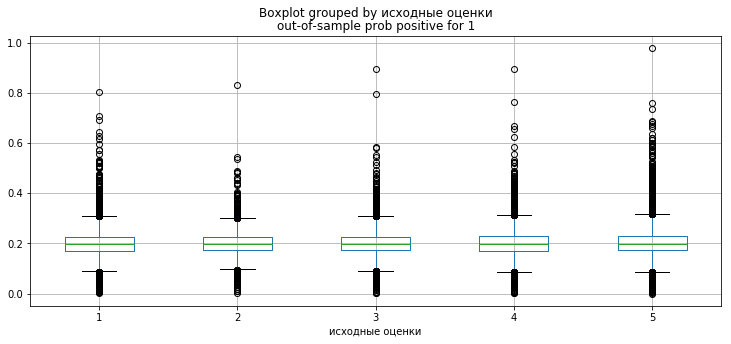

In [41]:
tag_index = 0
col_name = "out-of-sample prob positive for " + str(my_tags[tag_index])
probpos = pd.DataFrame({col_name:probs[[tag_index]].sum(axis=1), 
                        "исходные оценки": [r['y'] for r in revtest]})
probpos.boxplot(col_name,by="исходные оценки", figsize=(12,5))

In [42]:
target = [r['y'] for r in revtest]

accuracy 0.1935
confusion matrix
 [[1446 1425 1589 1061 1353]
 [ 830  855  969  604  798]
 [1246 1263 1402  825 1186]
 [2479 2493 2671 1787 2278]
 [4680 4486 4900 3189 4185]]
(row=expected, col=predicted)


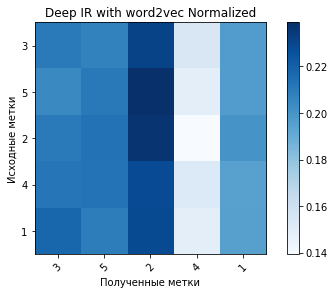

In [43]:
evaluate_prediction(predictions, target, "Deep IR with word2vec")